In [1]:
import ROOT
from rootpy.tree import Tree, TreeModel, FloatCol, IntCol
from rootpy.io import root_open
from ROOT import gROOT, TCanvas, TF1, TFile, TTree, gRandom, TH1F

from ROOT import RooRealVar, RooFormulaVar, RooVoigtian, RooChebychev, RooArgList, \
                 RooArgSet, RooAddPdf, RooDataSet, RooCategory, RooSimultaneous, \
                 RooBreitWigner, RooCBShape, RooFFTConvPdf, RooGaussian,RooExponential, \
                 RooBinning, kRed, kBlue, kDotted,TString,RooAbsData, RooPlot, TCut, RooAbsData, RooFit                

In [2]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

import os, sys, time, random

from ROOT import TTree, TFile

# from root_numpy import root2array, rec2array, array2root

import pandas as pd
import numpy as np
import scipy 
import root_pandas as rp


sys.path.append('/home/chasenberg/repos/root_utils/')
sys.path.append('/home/chasenberg/repos/root_numpy/')
import root_numpy as ry
from ROOT import TColor
import rootnotes  # For displaying TCanvas in notebooks
from lhcb_style import set_lhcb_style # Set basic LHCb plot style
set_lhcb_style()   
from root_utils import plot_pulls

In [3]:
#directories and files 
data_dir = '/fhgfs/users/chasenberg/data/2015/jpsiks/flattened/'
data_file ='Bd2JpsiKS_data_2015_flattened.root'
data_dir = os.path.join(data_dir, data_file)

In [4]:
#criteria and information for read in data
branch_names_data = [
'B0_M',
'B0_TAU',
'B0_TAUERR',
'B0_TAGDECISION_OS',
'B0_TAGOMEGA_OS',  
####Kinematics
'J_psi_1S_IP_OWNPV',
'J_psi_1S_IPCHI2_OWNPV',   
'J_psi_1S_M',
'J_psi_1S_PT',
'J_psi_1S_IP_OWNPV',  
'J_psi_1S_IPCHI2_OWNPV',
'B0_FitDaughtersConst*',
'B0_FitPVConst_KS0*',
'KS0_PT',
'KS0_IP_OWNPV',
'KS0_MINIPCHI2',
'KS0_IP_OWNPV', 
'KS0_IPCHI2_OWNPV',  
'KS0_TAU',
'KS0_TAUERR',
'piminus_PT',
'piminus_IP_OWNPV',
'piminus_IPCHI2_OWNPV',
'piminus_MINIPCHI2',
'muminus_PT',
'muminus_IP_OWNPV',
'muminus_IPCHI2_OWNPV',
'muminus_MINIPCHI2',
'muplus_PT',
'muplus_IP_OWNPV',
'muplus_IPCHI2_OWNPV',
'muplus_MINIPCHI2',
####Kinematics
'muplus_PIDmu',
'piminus_TRACK_Type',
'idxPV',
'B0_FitPVConst_status',
#'Hlt1GlobalDecision',
'B0_L0MuonDecision_TOS',
'B0_Hlt1TrackMuonDecision_TOS',
'B0_Hlt2DiMuonJPsiDecision_TOS', 
'B0_L0MuonDecision_Dec',
'B0_Hlt1TrackMuonDecision_Dec',
'B0_Hlt2DiMuonJPsiDecision_Dec', 
'Hlt1DiMuonHighMassDecision',
'Hlt1TrackMVADecision', 
'Hlt1TwoTrackMVADecision', 
#'HLT1TrackMuonMVADecision',
'L0PhysicsDecision',
'L0MuonDecision',
'L0DiMuonDecision',
'L0MuonHighDecision',
'L0HadronDecision',
'L0ElectronDecision',
'L0PhotonDecision',
#'Hlt2GlobalDecision',
'Hlt2DiMuonJPsiDecision',
'Hlt2DiMuonDetachedJPsiDecision'
]
cut_string_data = 'B0_FitDaughtersConst_status==0&B0_FitPVConst_status==0&idxPV==0&B0_FitDaughtersConst_M<5350&B0_FitDaughtersConst_M>5220'#&((B0_L0Global_TOS==1)|(B0_Hlt1DiMuonHighMassDecision_TOS==1)|(B0_Hlt2DiMuonDetachedJPsiDecision_TOS==1))'
tree_data = 'Bd2JpsiKs'
#read root files
df_data = rp.read_root(data_dir,key=tree_data,columns=branch_names_data,where=cut_string_data, flatten=True)
#Write a new ROOT tuple 
df_data.to_root('/fhgfs/users/chasenberg/data/2015/jpsiks/cut_branches/Bd2JpsiKS_data_2015_cut_branches.root',key='Bd2JpsiKs')

In [5]:
tree_name = 'Bd2JpsiKs'
data = ROOT.TFile('/fhgfs/users/chasenberg/data/2015/jpsiks/cut_branches/Bd2JpsiKS_data_2015_cut_branches.root',"READ")
tree_data = data.Get(tree_name) 
tree_data.GetEntries()

355203

In [6]:
B0_M = RooRealVar("B0_FitDaughtersConst_M", "B0_M", 5280, "MeV")
upper_limit_mass = 5350
lower_limit_mass = 5220
mass = RooRealVar("B0_FitDaughtersConst_M", "Mass(J/psi K_{S})", 5280,lower_limit_mass, upper_limit_mass, "MeV")
# Construct signal from two Gaussian pdf's with different means and sigmas 
mean = RooRealVar("mean", "mean", 5280,  5210,5360)
sigma_1 = RooRealVar("sigma_1", "sigma_1", 10, 0, 20)
sigma_2 = RooRealVar("sigma_2", "sigma_2", 15, 0, 20)
sig1frac = RooRealVar("sig1frac","fraction of component 1 in signal",0.8,0.,1.)

signal_1 = RooGaussian("signal_1", "signal_1", mass, mean, sigma_1)
signal_2 = RooGaussian("signal_2", "signal_2", mass, mean, sigma_2)
signal = RooAddPdf("DoubleGaussian","DoubleGaussian",signal_1, signal_2,sig1frac)
# Construct background pdf
lambda_1= RooRealVar("lambda","lambda",0.0,-0.1,0.0)
background = RooExponential("background","background",mass,lambda_1)
# Construct composite pdf
nsig = RooRealVar("nsig", "nsig", 35000,0,45000)
nbkg = RooRealVar("nbkg", "nbkg", 320000, 0, 400000)
model = RooAddPdf("model", "model", RooArgList(signal, background), RooArgList(nsig, nbkg))

In [7]:
ntupleVarSet =  RooArgSet(mass)
dataset = RooDataSet('data','data',tree_data,ntupleVarSet)
#Fit model to dataset
model.fitTo(dataset, ROOT.RooFit.Save(True)) 

<ROOT.RooFitResult object ("fitresult_model_data") at 0xe3309b0>

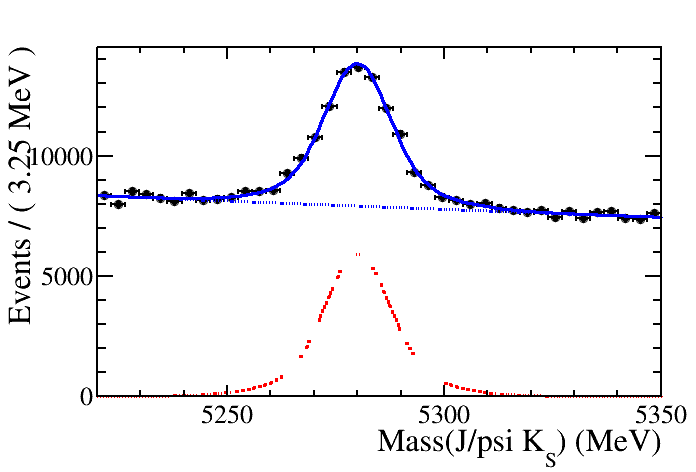

In [8]:
sys.path.append('/home/chasenberg/repos/root_utils/')
from ROOT import TColor
import rootnotes  # For displaying TCanvas in notebooks
from lhcb_style import set_lhcb_style # Set basic LHCb plot style
set_lhcb_style()   
from root_utils import plot_pulls


#Plot data and fit-function to same canvas
#canvas = rootnotes.canvas("c", (800, 800))
can =  ROOT.TCanvas('test')
plot = mass.frame() 
dataset.plotOn( plot , ROOT.RooFit.Binning(40) )
model.plotOn( plot )
model.plotOn( plot , ROOT.RooFit.Components("DoubleGaussian"), ROOT.RooFit.LineStyle(kDotted), ROOT.RooFit.LineColor(kRed))
model.plotOn( plot , ROOT.RooFit.Components("background"), ROOT.RooFit.LineStyle(kDotted), ROOT.RooFit.LineColor(kBlue))
#plot.GetYaxis().SetTitle( TString( plot.GetYaxis().GetTitle() ).ReplaceAll(")","MeV/c^{2} )").Data() )
#canvas.SetLogy(0)
plot.Draw()
#can, _ = plot_pulls('Data_massfit',plot, save_path='mc_mass_fit_adaboost/plots/', logy=False) 
can.SaveAs("/home/chasenberg/repos/b2cc_sin2beta/notebooks/mass_fit/plots/B0_Mass.pdf")
can
#canvas 

In [9]:
#Start to develop an SWeight model

In [10]:
from ROOT import RooStats

data_sweight = ROOT.RooStats.SPlot("sData","An SPlot", dataset,model, RooArgList(nsig, nbkg))
sWeight_sig =ROOT.RooDataSet("dataset_nsig","dataset_nsig", dataset, dataset.get(),"","nsig_sw")
sWeight_bkg = ROOT.RooDataSet("dataset_nbkg","dataset_nbkg", dataset, dataset.get(),"","nbkg_sw")
#signal_number = sWeight_sig.getVal()
#background_number = sWeight_bkg.getVal() 
#print("Number of background events:",signal_number,"signal_number")
#print("Number of background events:",background_number,"signal_number")d

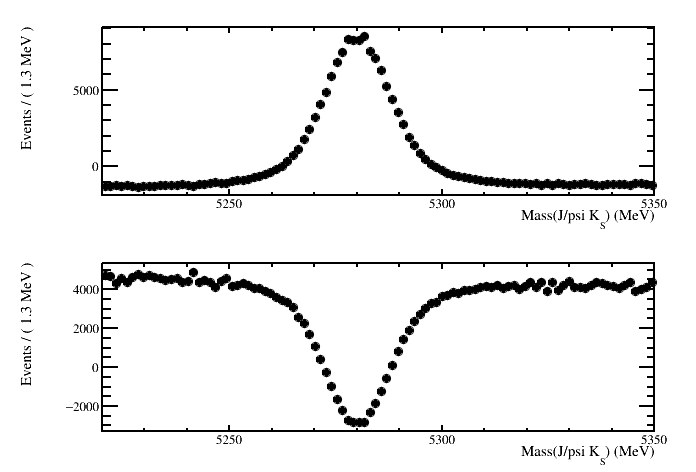

In [11]:
#Make splots of the signal and background
sig_frame = mass.frame() 
sig_frame.SetTitle("sPlot for the signal mass distribution")
sWeight_sig.plotOn(sig_frame, ROOT.RooFit.DataError(RooAbsData.SumW2))
bkg_frame = mass.frame() 
bkg_frame.SetTitle("sPlot for the background mass distribution")
sWeight_bkg.plotOn(bkg_frame)#, ROOT.RooFit.DataError(RooAbsData.SumW2))
c2 = ROOT.TCanvas("c2")
c2.Divide(1,2)

#Plot PDFs on sPlots
#signal.plotOn(sig_frame)
#background.plotOn(bkg_frame)
c2.cd(1)
sig_frame.Draw()
c2.cd(2)
bkg_frame.Draw()
c2

In [12]:
#Write Sweights to TTree

In [13]:
#Fill SWeights to numpy array
Weight_sig_array = []
Weight_bkg_array = []
num = sWeight_sig.numEntries()
for i in range(num):
    Weight_sig_array.append(data_sweight.GetSWeight(i,"nsig"))
    Weight_bkg_array.append(data_sweight.GetSWeight(i,"nbkg"))

In [14]:
#del Weight_sig_array[-1]
#del Weight_sig_array[-1]

In [15]:
'''#Create new dataframe to add SWeights to
data_file = '/fhgfs/users/chasenberg/data/2015/jpsiks/sweights/Bd2JpsiKS_data_flattened_cutstring.root'
df_data = rp.read_root(data_file,key='Bd2JpsiKs')

df_data['nsig_sw'] = Weight_sig_array
df_data.to_root('/fhgfs/users/chasenberg/data/2015/jpsiks/sweights/Bd2JpsiKS_data_2015_flattened_SWeights.root',key='Bd2JpsiKs')#,branches='nsig_sw')'''

"#Create new dataframe to add SWeights to\ndata_file = '/fhgfs/users/chasenberg/data/2015/jpsiks/sweights/Bd2JpsiKS_data_flattened_cutstring.root'\ndf_data = rp.read_root(data_file,key='Bd2JpsiKs')\n\ndf_data['nsig_sw'] = Weight_sig_array\ndf_data.to_root('/fhgfs/users/chasenberg/data/2015/jpsiks/sweights/Bd2JpsiKS_data_2015_flattened_SWeights.root',key='Bd2JpsiKs')#,branches='nsig_sw')"

In [16]:
from ROOT import TTreeFormula
# writing interim file and tree to have same number of events in ttree and dataset (restricted mass range)
entries = tree_data.GetEntries()

print('Creatin output file')
interim_file = TFile("/tmp/interim.root","recreate")
interim_tree = tree_data
cut_string = ""
formula = TTreeFormula("formula",cut_string,interim_tree)
interim_tree = tree_data.CopyTree(cut_string)
interim_tree.Write()
data.Close()

# now writing final File
new_file = TFile("/fhgfs/users/chasenberg/data/2015/jpsiks/sweights/Bd2JpsiKS_data_2015_flattened_sw.root","recreate")
new_tree = interim_tree.CloneTree()
interim_file.Close()

interim_entries = new_tree.GetEntries()

sig_weight = np.zeros(1, dtype=float)
bkg_weight = np.zeros(1, dtype=float)
sigweight_branch = new_tree.Branch('SigYield_sw',sig_weight,'SigYield_sw/D')
bkgweight_branch = new_tree.Branch('BkgYield_sw',bkg_weight,'BkgYield_sw/D')

for i in range(0,interim_entries):
  sig_weight[0] = Weight_sig_array[i]
  bkg_weight[0] = Weight_bkg_array[i]
  sigweight_branch.Fill()
  bkgweight_branch.Fill()
  
new_tree.Write()
new_file.Close()

# removing interim file
os.remove("/tmp/interim.root")

Creatin output file
